In [108]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [109]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [110]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [111]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Python Parser

In [13]:
import glob
import pandas as pd
import json

# projects = ["django", "flask", "pytorch", "pandas"]
projects = ["flask"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [14]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,test_add,"def test_add(client, a, b, result):\n respo...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1,/home/r4ph/desenv/exception-miner/projects/py/...,check,"def check(sender, template, context):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
2,/home/r4ph/desenv/exception-miner/projects/py/...,test_index,"def test_index(app, client, path, template_nam...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
3,/home/r4ph/desenv/exception-miner/projects/py/...,client,def client(app):\n return app.test_client(),0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
4,/home/r4ph/desenv/exception-miner/projects/py/...,fixture_app,def fixture_app():\n app.testing = True\n ...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask


In [7]:
df[df['str_uncaught_exceptions'].isnull() == False].shape

(5, 20)

In [8]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
356,/home/r4ph/desenv/exception-miner/projects/py/...,test_build_error_handler,def test_build_error_handler(app):\n # Test...,2,0,0,0,1,0,0,0,0,0,BuildError RuntimeError,RuntimeError,"error = err pytest.raises(BuildError, app.hand...",NaN,0,0,flask
435,/home/r4ph/desenv/exception-miner/projects/py/...,test_teardown_request_handler_error,"def test_teardown_request_handler_error(app, c...",2,2,0,2,2,0,0,0,0,0,Exception Exception,TypeError TypeError,pass pass,NaN,0,0,flask
1173,/home/r4ph/desenv/exception-miner/projects/py/...,wsgi_app,"def wsgi_app(self, environ: dict, start_respon...",2,0,1,1,1,0,1,0,0,1,Exception,NaN,error = e\n response = self.han...,NaN,0,0,flask
1308,/home/r4ph/desenv/exception-miner/projects/py/...,convert,"def convert(self, value, param, ctx):\n ...",3,0,0,0,3,0,1,0,0,1,ImportError click BadParameter ImportError Imp...,NaN,raise click.BadParameter(\n 'Us...,NaN,0,0,flask
1315,/home/r4ph/desenv/exception-miner/projects/py/...,list_commands,"def list_commands(self, ctx):\n self._l...",2,0,0,1,0,0,0,0,0,0,NoAppException Exception,NaN,"click.secho(f""Error: {e.format_message()}\n"", ...",NaN,0,0,flask
1332,/home/r4ph/desenv/exception-miner/projects/py/...,find_app_by_string,"def find_app_by_string(module, app_name):\n ...",4,0,0,0,8,0,0,0,0,0,SyntaxError ValueError AttributeError TypeError,NoAppException NoAppException NoAppException N...,"raise NoAppException(\n f""Failed to...",NaN,0,0,flask


In [9]:
df.shape

(1412, 20)

In [15]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
157,/home/r4ph/desenv/exception-miner/projects/py/...,hello_command,"def hello_command():\n click.echo(""Hell...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
162,/home/r4ph/desenv/exception-miner/projects/py/...,view,def view(company_id):\n return company_id,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
187,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
193,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n flask.g.user_agent = fla...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
195,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,/home/r4ph/desenv/exception-miner/projects/py/...,index,"def index():\n return f""Hello {flask.re...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1015,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1017,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1088,/home/r4ph/desenv/exception-miner/projects/py/...,to_json,"def to_json(self, value: t.Any) -> t.Any:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask


In [16]:
df = df.drop_duplicates()

Analyzing the Control Flow and Code

In [17]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]
filenames = glob.glob(f"../output/parser/*.csv")

for filename in filenames:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(filename)
    project = filename.split("/")[-1].split("_")[0]
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [18]:
df.project.unique()

array(['bert', 'python-100-days', 'fastapi', 'rich', 'faceswap',
       'youcompleteme', 'ailearning', 'sherlock', 'youtube-dl',
       'cheat.sh', 'real-time-voice-cloning', 'face',
       'system-design-primer', 'detectron', 'yolov5', 'you-get',
       'ansible', 'gfpgan', 'django', 'thefuck', 'mitmproxy',
       'mockingbird', 'scrapy', 'django-rest-framework', 'jieba',
       'scikit-learn', 'public-apis', 'certbot', 'localstack', 'd2l-zh',
       'python-cheatsheet', 'cppcoreguidelines', 'keras', 'diagrams',
       'transformers', 'models', 'wtfpython',
       'interactive-coding-challenges', 'sentry', 'httpie',
       'awesome-python', 'algo', 'hellogithub',
       'big-list-of-naughty-strings', 'sqlmap', 'xx-net', '12306',
       'deep-learning-papers-reading-roadmap', 'hanlp', 'gym',
       'python-patterns', 'requests', 'flask', 'manim', 'python-fire',
       'data-science-ipython-notebooks', 'deepfacelab', 'black',
       'hackingtool', 'openpilot', 'linux-insides', 'pytorch-

In [19]:
len(df.project.unique())

65

In [20]:
df.shape

(235869, 20)

In [21]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main(_):\n tf.logging.set_verbosity(tf.lo...,0,0,0,0,3,0,0,0,0,0,NaN,ValueError ValueError ValueError,NaN,...run_classifier_with_tfhub.model_fn_builder:...,0,0,bert
1,/home/r4ph/desenv/exception-miner/projects/py/...,convert_examples_to_features,"def convert_examples_to_features(examples, lab...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,bert
2,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn,"def input_fn(params):\n """"""The actual input...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,bert
3,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn_builder,"def input_fn_builder(features, seq_length, is_...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,bert
4,/home/r4ph/desenv/exception-miner/projects/py/...,metric_fn,"def metric_fn(per_example_loss, label_ids, log...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,bert


In [22]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
220,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n os.environ.setdefault('DJANGO...,1,0,0,0,1,0,0,0,0,0,ImportError,ImportError,"raise ImportError(\n ""Couldn't impo...",NaN,0,0,python-100-days
232,/home/r4ph/desenv/exception-miner/projects/py/...,fib,"def fib(num, results={}):\n """"""斐波拉切数""""""\n ...",1,0,0,0,0,0,0,0,0,1,KeyError,NaN,results[num] = fib(num - 1) + fib(num - 2)\n ...,NaN,0,0,python-100-days
577,/home/r4ph/desenv/exception-miner/projects/py/...,run,def run(self):\n try:\n ...,2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,NaN,0,0,python-100-days
579,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n\n class ClientHandler(Thread)...,2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,NaN,0,0,python-100-days
593,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n # 通过sys.argv获取命令行参数\n if l...,1,0,0,0,0,0,0,0,0,0,FileNotFoundError,NaN,print('不能执行%s命令' % sys.argv[index]),NaN,0,0,python-100-days
646,/home/r4ph/desenv/exception-miner/projects/py/...,find_contacters_by_name,def find_contacters_by_name(con):\n name = ...,1,0,0,0,0,0,0,0,0,0,pymysql MySQLError,NaN,print(err),NaN,0,0,python-100-days
647,/home/r4ph/desenv/exception-miner/projects/py/...,find_all_contacters,"def find_all_contacters(con):\n page, size ...",1,0,0,0,0,0,0,0,0,0,pymysql MySQLError,NaN,print(err),NaN,0,0,python-100-days
650,/home/r4ph/desenv/exception-miner/projects/py/...,edit_contacter_info,"def edit_contacter_info(con, contacter):\n ...",1,0,0,0,0,0,0,0,0,0,pymysql MySQLError,NaN,print(err)\n print('更新联系人信息失败!'),NaN,0,0,python-100-days
651,/home/r4ph/desenv/exception-miner/projects/py/...,delete_contacter,"def delete_contacter(con, contacter):\n try...",1,0,0,0,0,0,0,0,0,0,pymysql MySQLError,NaN,print(err)\n print('删除联系人失败!'),NaN,0,0,python-100-days
652,/home/r4ph/desenv/exception-miner/projects/py/...,add_new_contacter,"def add_new_contacter(con):\n name, tel, em...",1,0,0,0,0,0,0,0,0,0,pymysql MySQLError,NaN,print(err)\n print('添加联系人失败!'),NaN,0,0,python-100-days


In [23]:
df.iloc[428,:].func_body

"def reverse_str5(str):\n    # 将字符串处理成列表\n    str_list = list(str)\n    str_len = len(str)\n    # 使用zip函数将两个序列合并成一个产生元组的迭代器\n    # 每次正好可以取到一前一后两个下标来实现元素的交换\n    for i, j in zip(range(str_len // 2), range(str_len - 1, str_len // 2, -1)):\n        str_list[i], str_list[j] = str_list[j], str_list[i]\n    # 将列表元素连接成字符串\n    return ''.join(str_list)"

In [24]:
df.iloc[428,:].str_except_identifiers

nan

In [25]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
11350,/home/r4ph/desenv/exception-miner/projects/py/...,test_FromWatchdogWithSubservers,def test_FromWatchdogWithSubservers( self ):\n...,1,1,2,0,0,0,0,0,0,0,requests exceptions ConnectionError,NaN,pass,NaN,0,0,youcompleteme
13569,/home/r4ph/desenv/exception-miner/projects/py/...,parse_paren,"def parse_paren(source, info):\n """"""Parses ...",0,0,2,0,1,0,0,0,0,0,NaN,error,NaN,...third_party.ycmd.third_party.mrab-regex.reg...,0,0,youcompleteme
14105,/home/r4ph/desenv/exception-miner/projects/py/...,parse_paren,"def parse_paren(source, info):\n """"""Parses ...",0,0,2,0,1,0,0,0,0,0,NaN,error,NaN,NaN,0,0,youcompleteme
19515,/home/r4ph/desenv/exception-miner/projects/py/...,mountpoint_wrapper,def mountpoint_wrapper():\n try:\n ...,0,0,2,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,0,0,youcompleteme
19516,/home/r4ph/desenv/exception-miner/projects/py/...,mount,"def mount(self, prefix, app, **options):\n ...",0,0,2,0,1,0,0,0,0,1,NaN,ValueError,NaN,NaN,0,0,youcompleteme
21129,/home/r4ph/desenv/exception-miner/projects/py/...,win_uninstall_service,def win_uninstall_service(service_name):\n ...,0,0,2,0,2,0,0,0,0,0,NaN,OSError OSError,NaN,...devscripts.buildserver.win_OpenSCManager:Ex...,0,0,youtube-dl
28241,/home/r4ph/desenv/exception-miner/projects/py/...,write_data,"def write_data(self, data, thefile, shred=True...",3,1,2,1,3,0,0,0,0,0,Exception OSError OSError,AnsibleError AnsibleError AnsibleError,pass if ose.errno == errno.EEXIST:\n ...,NaN,1,0,ansible
28782,/home/r4ph/desenv/exception-miner/projects/py/...,_display_progress,def _display_progress(msg=None):\n config_d...,2,0,2,1,1,0,1,0,1,0,queue Empty Exception,NaN,break raise,NaN,0,0,ansible
29710,/home/r4ph/desenv/exception-miner/projects/py/...,atomic_move,"def atomic_move(self, src, dest, unsafe_writes...",10,1,2,0,3,0,0,0,0,0,OSError OSError IOError OSError OSError IOErro...,NaN,"for err in 'EOPNOTSUPP', 'ENOTSUP':\n ...",NaN,3,0,ansible
30495,/home/r4ph/desenv/exception-miner/projects/py/...,run,"def run(self, tmp=None, task_vars=None):\n ...",7,0,3,1,10,0,1,0,0,0,TypeError AnsibleError AnsibleFileNotFound Uni...,AnsibleActionFail AnsibleActionFail AnsibleAct...,raise AnsibleActionFail(to_native(e)) raise An...,NaN,1,0,ansible


In [26]:
df.iloc[500, :].func_body

'def accelerate(self, delta):\n        self._current_speed += delta\n        if self._current_speed > self._max_speed:\n            self._current_speed = self._max_speed'

In [11]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [27]:
df[df['n_try_except'] >1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
577,/home/r4ph/desenv/exception-miner/projects/py/...,run,def run(self):\n try:\n ...,2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,NaN,0,0,python-100-days
579,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n\n class ClientHandler(Thread)...,2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,NaN,0,0,python-100-days
1675,/home/r4ph/desenv/exception-miner/projects/py/...,create_item,async def create_item(request: Request):\n ...,2,0,0,0,2,0,0,0,0,0,yaml YAMLError ValidationError,HTTPException HTTPException,"raise HTTPException(status_code=422, detail=""I...",NaN,0,0,fastapi
1788,/home/r4ph/desenv/exception-miner/projects/py/...,check_file_field,def check_file_field(field: ModelField) -> Non...,2,0,0,0,2,0,0,0,0,0,ImportError ImportError,RuntimeError RuntimeError,logger.error(multipart_incorrect_install_error...,NaN,0,0,fastapi
1869,/home/r4ph/desenv/exception-miner/projects/py/...,app,async def app(request: Request) -> Response:\n...,3,0,0,1,4,0,1,0,0,0,json JSONDecodeError HTTPException Exception,RequestValidationError HTTPException RequestVa...,raise RequestValidationError(\n ...,NaN,0,0,fastapi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235629,/home/r4ph/desenv/exception-miner/projects/py/...,inner,"def inner(df, func, *args, **kwargs):\n ...",2,1,1,0,0,0,0,0,0,1,ImportError TypeError,NaN,is_builtin_func = df._is_builtin_func pass,NaN,0,0,tqdm
235630,/home/r4ph/desenv/exception-miner/projects/py/...,inner_generator,def inner_generator(df_function='apply'):\n ...,2,1,1,0,0,0,0,0,0,1,ImportError TypeError,NaN,is_builtin_func = df._is_builtin_func pass,NaN,0,0,tqdm
235631,/home/r4ph/desenv/exception-miner/projects/py/...,pandas,"def pandas(cls, **tqdm_kwargs):\n """"""\n...",11,1,1,0,0,0,0,0,0,1,ImportError ImportError ImportError ImportErro...,NaN,Panel = None try: # pandas>=0.18.0\n ...,NaN,1,0,tqdm
235639,/home/r4ph/desenv/exception-miner/projects/py/...,format_meter,"def format_meter(n, total, elapsed, ncols=None...",2,1,0,0,0,0,0,0,0,0,TypeError OverflowError,NaN,pass eta_dt = datetime.max,NaN,0,0,tqdm


In [28]:
df.str_except_block

0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
235864                          NaN
235865                          NaN
235866    sys.setcheckinterval(100)
235867                          NaN
235868                          NaN
Name: str_except_block, Length: 235869, dtype: object

In [29]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,323621
1,=,5012
2,raise,4405
3,return,2886
4,if,2228
5,to,2028
6,pass,1768
7,%,1661
8,not,1525
9,in,1371


In [30]:
df.str_except_identifiers.unique()

array([nan, 'ImportError', 'KeyError', ..., 'TypeError OverflowError',
       'TqdmDeprecationWarning TqdmDeprecationWarning',
       'TqdmDeprecationWarning'], dtype=object)

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [48]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [49]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [50]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,235863.0,9907.0,20909.0,1411.0,887.0,4.20032,8.864892,14.242455,8.953265


In [19]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [20]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [51]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [52]:
df_total.columns = ['try-except', 'raise', 'try-else', 'try-finally']
df_total

,try-except,raise,try-else,try-finally
0,4.20032,8.864892,8.953265,14.242455


In [53]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,try-except,4.200320
1,raise,8.864892
2,try-else,8.953265
3,try-finally,14.242455


In [54]:
#rename columns:
df_total.columns = ['Exception Handling', 'Percentage']
df_total['Percentage'] = df_total['Percentage'].round(2)


In [55]:
df_total = df_total.sort_values(by=['Percentage'], ascending=False)
df_total

,Exception Handling,Percentage
3,try-finally,14.24
2,try-else,8.95
1,raise,8.86
0,try-except,4.20


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


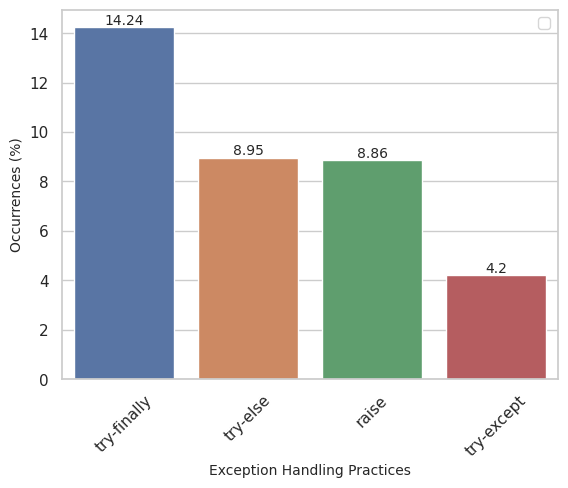

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total, x="Exception Handling", y="Percentage")
plt.ylabel("Occurrences (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)



In [42]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [43]:
df_except_types

,index,str_except_identifiers
0,Exception,2869
1,ValueError,1401
2,KeyError,986
3,AttributeError,755
4,DoesNotExist,617
...,...,...
1216,DependencyError,1
1217,curses,1
1218,RuleActivity,1
1219,GroupInbox,1


In [29]:
#df_except_types = df_except_types[1:]

In [44]:
def get_capitalized_elements(list):
    for element in list:
        if element[0].isupper():
            return element

In [45]:
#TODO: get a list of built-in exceptions and flag them
df_except_types['str_uniq_identifiers'] = df_except_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_except_types = df_except_types[df_except_types['str_uniq_identifiers'].notna()].head(20)

In [46]:
df_except_types = df_except_types.head(20) 
df_except_types['perc'] =  ((df_except_types['str_except_identifiers']/ df_except_types['str_except_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


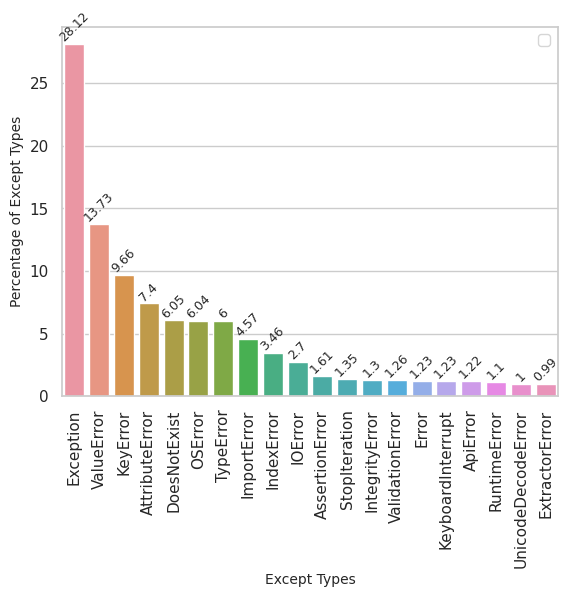

In [47]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_except_types, x="str_uniq_identifiers", y="perc")
plt.ylabel("Percentage of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)


In [34]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,NotImplementedError,2999
2,TypeError,1911
3,Exception,1881
4,RuntimeError,1832
5,SystemExit,959
6,ValidationError,722
7,AnsibleError,503
8,ExtractorError,490
9,AssertionError,481
10,JsonableError,474


In [35]:
df_raise_types['str_uniq_identifiers'] = df_raise_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_raise_types = df_raise_types[df_raise_types['str_uniq_identifiers'].notna()].head(20)

In [36]:
df_raise_types = df_raise_types.head(20) 
df_raise_types['perc'] =  ((df_raise_types['str_raise_identifiers']/ df_raise_types['str_raise_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


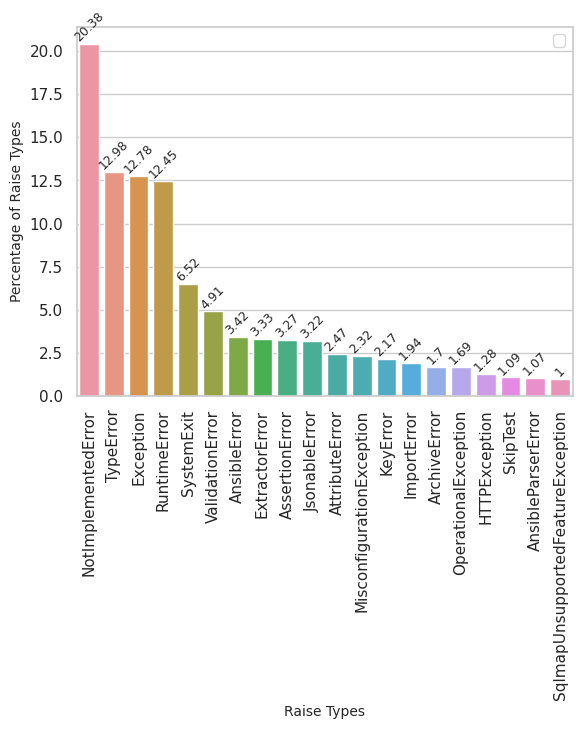

In [37]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_raise_types, x="index", y="perc")
plt.ylabel("Percentage of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)

RQ2. 

In [57]:
df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.values

#df.str_uncaught_exceptions.str.split("[.][.][.]").values

array(['...run_classifier_with_tfhub.model_fn_builder:ValueError ...extract_features.model_fn_builder:ValueError ...run_pretraining.model_fn_builder:ValueError ...run_squad.read_squad_examples:ValueError ...run_squad.model_fn_builder:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError',
       '...modeling.embedding_postprocessor:ValueError ...modeling.get_activation:ValueError ...modeling.transformer_model:ValueError ...modeling.transformer_model:ValueError',
       '...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError',
       ..., '...tests.tests_tqdm.squash_ctrlchars:

In [58]:
import numpy as np
#Couting uncaught exceptions:
#df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.str.split("[.][.][.]").values[3]

df['n_uncaught_exceptions'] = df['str_uncaught_exceptions'].str.split("[.][.][.]").apply(lambda x: len(x)-1 if x is not np.nan else 0)

In [68]:
df.columns

Index(['file', 'function', 'func_body', 'n_try_except', 'n_try_pass',
       'n_finally', 'n_generic_except', 'n_raise', 'n_captures_broad_raise',
       'n_captures_try_except_raise', 'n_captures_misplaced_bare_raise',
       'n_try_else', 'n_try_return', 'str_except_identifiers',
       'str_raise_identifiers', 'str_except_block', 'str_uncaught_exceptions',
       'n_nested_try', 'n_bare_except', 'project', 'n_try_except_uni',
       'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions', 'n_try_pass_uni', 'n_generic_except_uni',
       'n_captures_try_except_raise_uni', 'n_captures_broad_raise_uni'],
      dtype='object')

In [75]:
cols = ['n_captures_misplaced_bare_raise', 'n_generic_except', 'n_captures_broad_raise', 'n_try_pass', 'n_try_return', 'n_nested_try', 'n_uncaught_exceptions']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [76]:
df.columns

Index(['file', 'function', 'func_body', 'n_try_except', 'n_try_pass',
       'n_finally', 'n_generic_except', 'n_raise', 'n_captures_broad_raise',
       'n_captures_try_except_raise', 'n_captures_misplaced_bare_raise',
       'n_try_else', 'n_try_return', 'str_except_identifiers',
       'str_raise_identifiers', 'str_except_block', 'str_uncaught_exceptions',
       'n_nested_try', 'n_bare_except', 'project', 'n_try_except_uni',
       'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions', 'n_try_pass_uni', 'n_generic_except_uni',
       'n_captures_try_except_raise_uni', 'n_captures_broad_raise_uni',
       'n_captures_misplaced_bare_raise_uni', 'n_try_return_uni',
       'n_nested_try_uni', 'n_uncaught_exceptions_uni'],
      dtype='object')

In [74]:
df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']})
df_rq2 = df_rq2.max().to_frame().T

In [61]:
df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions
0,235863.0,9907.0,1499.0,2394.0,20909.0,600.0,982.0,4602.0


In [62]:
#Trys
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_uncaught_exceptions'] = (df_rq2['n_uncaught_exceptions']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_try_except_raise_uni'] = (df_rq2['n_captures_try_except_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,235863.0,9907.0,1499.0,2394.0,20909.0,600.0,982.0,4602.0,15.130716,24.164732,46.452004,2.869578,4.696542


In [65]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,15.130716,24.164732,2.869578,4.696542,46.452004


In [64]:
df_total_rq2.columns = ['CWE-1069', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2

,CWE-1069,CWE-396,CWE-252,CWE-397,CWE-248
0,15.130716,24.164732,2.869578,4.696542,46.452004


In [46]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,CWE-1069,16.218119
1,CWE-396,29.079956
2,CWE-252,3.394825
3,CWE-397,6.285068
4,CWE-248,42.864966


In [47]:
#rename columns:
df_total_rq2.columns = ['Exception Handling', 'Percentage']
df_total_rq2['Percentage'] = df_total_rq2['Percentage'].round(2)

#order by percentage:
df_total_rq2 = df_total_rq2.sort_values(by=['Percentage'], ascending=False)
df_total_rq2

,Exception Handling,Percentage
4,CWE-248,42.86
1,CWE-396,29.08
0,CWE-1069,16.22
3,CWE-397,6.29
2,CWE-252,3.39


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


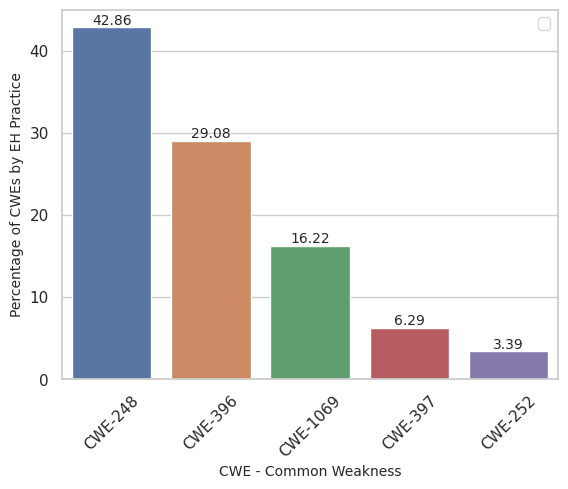

In [48]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total_rq2, x="Exception Handling", y="Percentage")
plt.ylabel("Percentage of CWEs by EH Practice", fontsize= 10)
plt.xlabel("CWE - Common Weakness", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

In [49]:
df_rq2_box = df[['project', 'function', 'n_try_except_uni', 'n_try_pass_uni', 'n_generic_except_uni', 'n_raise_uni', 'n_captures_try_except_raise_uni', 'n_captures_broad_raise_uni', 'n_uncaught_exceptions']]
df_rq2_box = df.groupby('project').agg( {'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']}).droplevel(1, axis=1).reset_index()

In [50]:
#Trys
df_rq2_box['perc_n_try_pass_uni'] = (df_rq2_box['n_try_pass_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_n_generic_except_uni'] = (df_rq2_box['n_generic_except_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_uncaught_exceptions'] = (df_rq2_box['n_uncaught_exceptions']/ df_rq2_box['n_try_except_uni']) * 100

#Raise
df_rq2_box['perc_n_captures_try_except_raise_uni'] = (df_rq2_box['n_captures_try_except_raise_uni']/ df_rq2_box['n_raise_uni']) * 100
df_rq2_box['perc_n_captures_broad_raise_uni'] = (df_rq2_box['n_captures_broad_raise_uni']/ df_rq2_box['n_raise_uni']) * 100

df_rq2_box

,project,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,algo,46,12,0,5,0,0,0,0,0.000000,41.666667,0.000000,NaN,NaN
1,ansible,9754,1172,214,361,1283,80,140,518,18.259386,30.802048,44.197952,6.235386,10.911925
2,archivebox,9103,1174,278,587,1029,124,109,0,23.679727,50.000000,0.000000,12.050534,10.592809
3,autojump,215,16,2,0,20,1,0,0,12.500000,0.000000,0.000000,5.000000,0.000000
4,aws-cli,6364,170,12,35,317,4,7,43,7.058824,20.588235,25.294118,1.261830,2.208202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,vit-pytorch,625,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
67,yapf,1187,21,1,4,22,5,0,3,4.761905,19.047619,14.285714,22.727273,0.000000
68,youtube-dl,3750,251,33,30,519,78,6,25,13.147410,11.952191,9.960159,15.028902,1.156069
69,zipline,4440,194,29,13,514,12,9,8,14.948454,6.701031,4.123711,2.334630,1.750973


In [51]:
df_total_rq2_box = df_rq2_box.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2_box

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,0.000000,41.666667,NaN,NaN,0.000000
1,18.259386,30.802048,6.235386,10.911925,44.197952
2,23.679727,50.000000,12.050534,10.592809,0.000000
3,12.500000,0.000000,5.000000,0.000000,0.000000
4,7.058824,20.588235,1.261830,2.208202,25.294118
...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN
67,4.761905,19.047619,22.727273,0.000000,14.285714
68,13.147410,11.952191,15.028902,1.156069,9.960159
69,14.948454,6.701031,2.334630,1.750973,4.123711


In [52]:
df_total_rq2_box.columns = ['CWE-391', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2_box

,CWE-391,CWE-396,CWE-252,CWE-397,CWE-248
0,0.000000,41.666667,NaN,NaN,0.000000
1,18.259386,30.802048,6.235386,10.911925,44.197952
2,23.679727,50.000000,12.050534,10.592809,0.000000
3,12.500000,0.000000,5.000000,0.000000,0.000000
4,7.058824,20.588235,1.261830,2.208202,25.294118
...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN
67,4.761905,19.047619,22.727273,0.000000,14.285714
68,13.147410,11.952191,15.028902,1.156069,9.960159
69,14.948454,6.701031,2.334630,1.750973,4.123711


In [53]:
#df_total_rq2 = df_total_rq2_box.T[0:].reset_index()
df_total_rq2_box.T[0:].reset_index()

,index,0,1,2,3,4,5,6,7,8,...,61,62,63,64,65,66,67,68,69,70
0,CWE-391,0.000000,18.259386,23.679727,12.5,7.058824,21.212121,14.285714,25.988701,8.695652,...,16.883117,10.389610,19.306931,25.000000,17.241379,NaN,4.761905,13.147410,14.948454,9.815951
1,CWE-396,41.666667,30.802048,50.000000,0.0,20.588235,15.151515,24.338624,16.572505,6.521739,...,37.012987,2.597403,32.673267,31.250000,0.000000,NaN,19.047619,11.952191,6.701031,11.451943
2,CWE-252,NaN,6.235386,12.050534,5.0,1.261830,2.857143,0.516796,3.193277,4.738155,...,2.834008,0.000000,7.758621,13.953488,0.000000,NaN,22.727273,15.028902,2.334630,2.647413
3,CWE-397,NaN,10.911925,10.592809,0.0,2.208202,0.000000,0.000000,2.016807,1.995012,...,4.858300,1.732673,16.666667,0.000000,0.000000,NaN,0.000000,1.156069,1.750973,5.655836
4,CWE-248,0.000000,44.197952,0.000000,0.0,25.294118,51.515152,55.555556,8.474576,8.695652,...,82.467532,0.000000,0.000000,20.312500,189.655172,NaN,14.285714,9.960159,4.123711,87.525562
